In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim.downloader as api

In [42]:
df = pd.read_csv('data/processed.csv')
df.head()

,Paper_ID,Date,Title,Authors,Abstract
0,9511170,1995-11-23,Einstein-Infeld-Hoffman method and soliton dyn...,['JacekDziarmaga'],We consider slow motion of a pointlike topolog...
1,9211024,1992-11-04,Discretization of the Superparticle Path Integral,"['J.Grundberg', 'U.Lindstrom', 'H.Nordstrom']",Requiring that the path integral has the globa...
2,9806180,1998-06-21,Comments on N=2 AdS Orbifolds,['SergeiGukov'],We discuss twisted states of AdS orbifolds whi...
3,108199,2001-08-27,Determinant Line Bundles and Topological Invar...,"['A.A.Bytsenko', 'M.C.Falleiros', 'A.E.Goncalv...",We give some remarks on twisted determinant li...
4,110123,2001-10-15,Entropy of the three dimensional Schwarzschild...,[''],We study the three dimensional Schwarzschild-d...


In [43]:
word_vectors = api.load("glove-wiki-gigaword-50")

In [44]:
texts = df['Abstract'].tolist()

In [45]:
def get_weighted_text_embedding(text, word_vectors, tfidf_weights):
    words = text.split()
    word_embeddings = []
    weights = []
    for word in words:
        if word in word_vectors and word in tfidf_weights:
            word_embeddings.append(word_vectors[word] * tfidf_weights[word])
            weights.append(tfidf_weights[word])
    
    if not word_embeddings:
        return None

    weighted_embedding = np.average(word_embeddings, axis=0, weights=weights)
    return weighted_embedding

vectorizer = TfidfVectorizer()
vectorizer.fit(texts)
tfidf_matrix = vectorizer.transform(texts)
tfidf_feature_names = vectorizer.get_feature_names_out()

text_embeddings = []
for i, text in tqdm(enumerate(texts), total=len(texts)):
    tfidf_weights = {word: tfidf_matrix[i, idx] for word, idx in zip(tfidf_feature_names, range(len(tfidf_feature_names)))}
    embedding = get_weighted_text_embedding(text, word_vectors, tfidf_weights)
    if embedding is not None:
        text_embeddings.append(embedding)
np.save('embeddings.npy', np.array(text_embeddings))

100%|██████████| 29555/29555 [2:03:37<00:00,  3.98it/s]  


Computing texts embeddings takes much time (~2 hours), so let's save them as numpy array

In [46]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [51]:
def distance_by_n(x, n):
    model = KMeans(n_clusters=n)
    model.fit(x)
    return model.inertia_

In [52]:
def elbow_method(data, max_clusters=10):
    distances = [distance_by_n(data, n) for n in range(1, max_clusters)]
    plt.plot(range(1, 10), distances)
    plt.title('Elbow method')

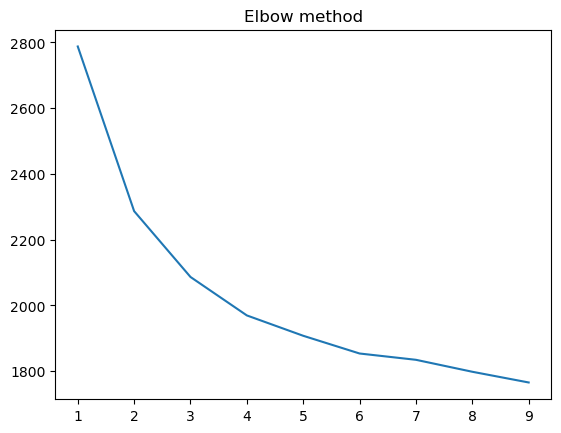

In [54]:
elbow_method(text_embeddings)

Let's say num_clusters = 3

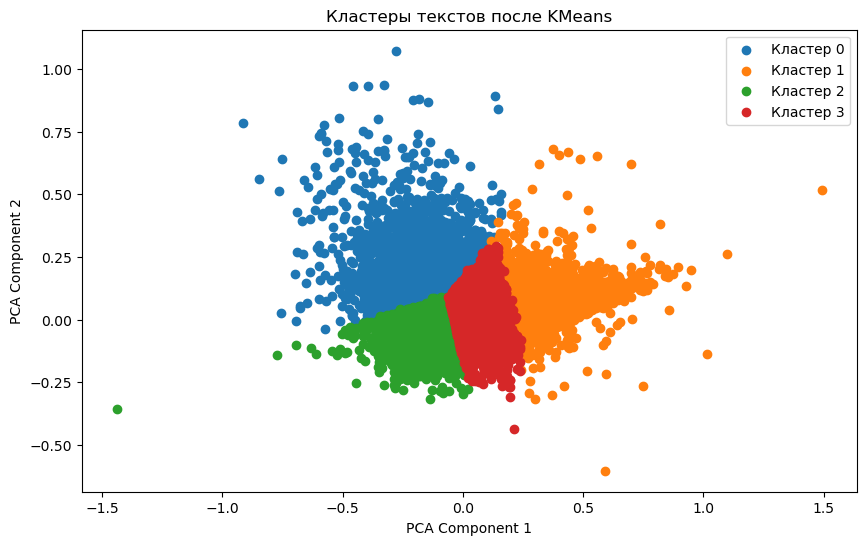

In [ ]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(text_embeddings)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(text_embeddings)

plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    plt.scatter(reduced_embeddings[clusters == cluster, 0], reduced_embeddings[clusters == cluster, 1], label=f"cluster {cluster+1}")
plt.legend()
plt.title("Text clusters after KMeans")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()